In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


## Fetch data

In [3]:
def get_data(ticker):

    # Get table from database
    df = yf.download(ticker,period = "10y")
    
    # Sort DataFrame ascending by date
    df.sort_index(ascending=True, inplace=True)

    # Create "return" column
    df['return'] = df['Close'].pct_change()*100

    # Return returns
    return df['return'].dropna()


### Load data for S&P 500 of last 10 yrs

In [4]:
ticker = "SPY"
y = get_data(ticker=ticker)
y.tail()

[*********************100%***********************]  1 of 1 completed


Date
2023-05-01   -0.100974
2023-05-02   -1.123923
2023-05-03   -0.686400
2023-05-04   -0.708295
2023-05-05    1.851258
Name: return, dtype: float64

## Data Exploration

### Daily Returns

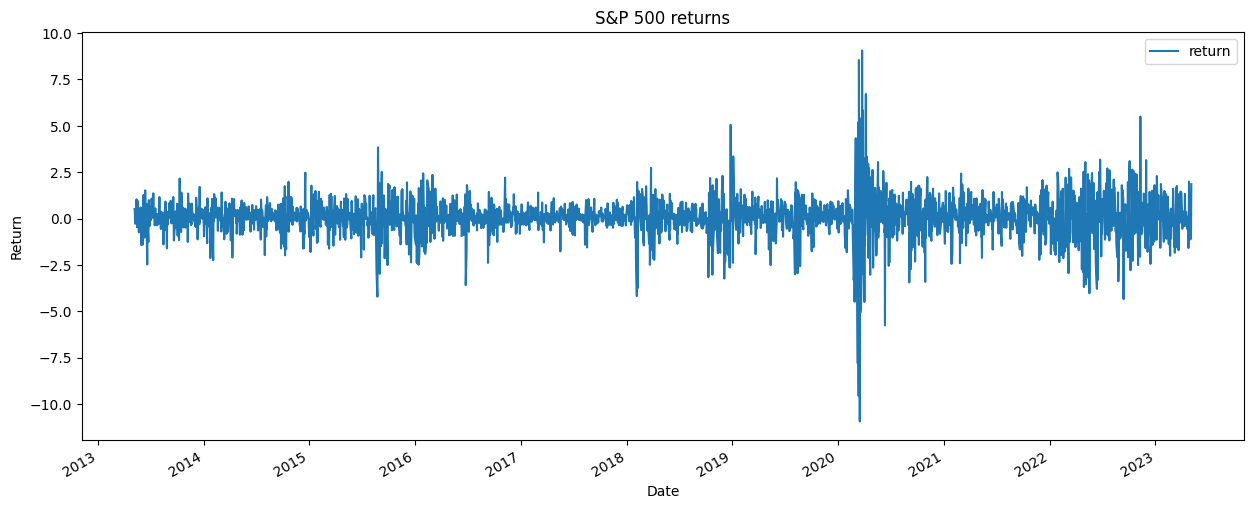

In [5]:
fig, ax = plt.subplots(figsize=(15, 6))
# Plot returns for S&P 500
y.plot(ax=ax)
# Label axes
plt.xlabel("Date")
plt.ylabel("Return")
plt.title('S&P 500 returns')
# Add legend
plt.legend();

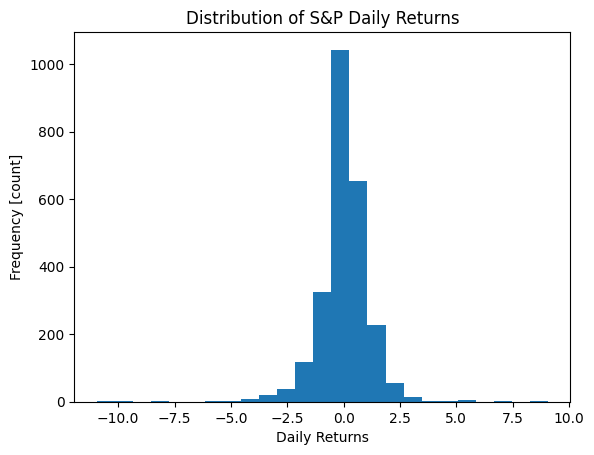

In [6]:
# Create histogram of `y`, 25 bins

plt.hist(y, bins=25)
# Add axis labels
plt.xlabel('Daily Returns')
plt.ylabel('Frequency [count]')


# Add title
plt.title('Distribution of S&P Daily Returns');

### Volatality

In [7]:
spy_daily_volatility = y.std()
spy_annual_volatility = spy_daily_volatility * np.sqrt(252)

print("S&P Daily Volatility:", spy_daily_volatility)
print("S&P Annual Volatility:", spy_annual_volatility)


S&P Daily Volatility: 1.1069686876144385
S&P Annual Volatility: 17.5725831393801


In [10]:
rolling_50d_volatility = y.rolling(window=50).std().dropna()

print("rolling_50d_volatility type:", type(rolling_50d_volatility))
print("rolling_50d_volatility shape:", rolling_50d_volatility.shape)
rolling_50d_volatility.head()

rolling_50d_volatility type: <class 'pandas.core.series.Series'>
rolling_50d_volatility shape: (2469,)


Date
2013-07-17    0.830401
2013-07-18    0.830852
2013-07-19    0.829214
2013-07-22    0.827786
2013-07-23    0.828067
Name: return, dtype: float64

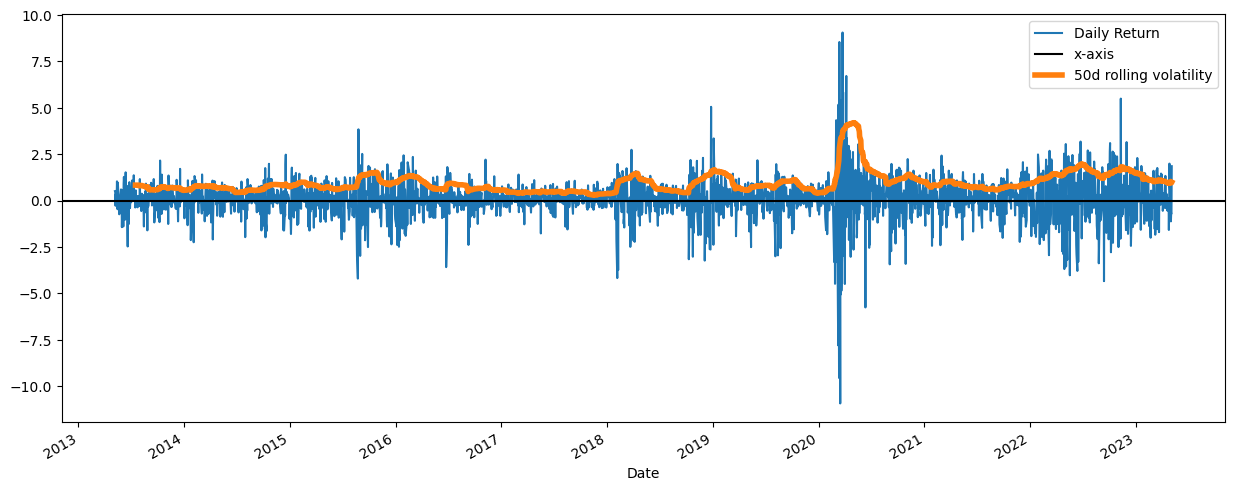

In [11]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_ambuja`
y.plot(ax=ax, label="Daily Return").axhline(y=0, color='black', label='x-axis')

# Plot `rolling_50d_volatility`
rolling_50d_volatility.plot(ax=ax, label="50d rolling volatility", linewidth=4)

# Add x-axis label
plt.xlabel('Date')
# Add legend
plt.legend()

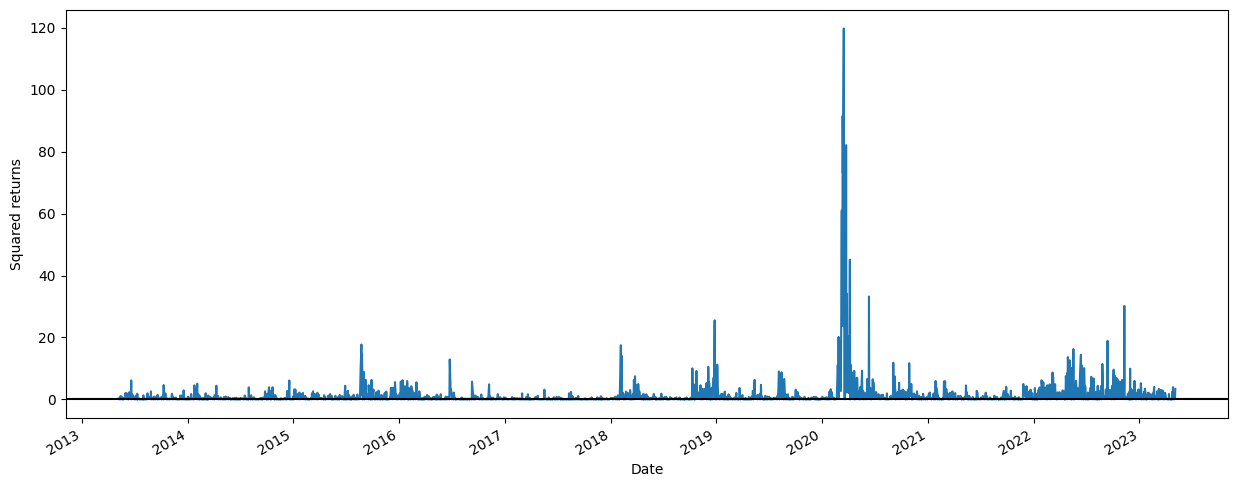

In [12]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot squared returns
(y**2).plot(ax=ax, label="Daily Return").axhline(y=0, color='black', label='x-axis')

# Add axis labels
plt.xlabel('Date')
plt.ylabel('Squared returns');

### ACF and PACF plots
To see how many lags we should have in our model, we should create an ACF and PACF plot.

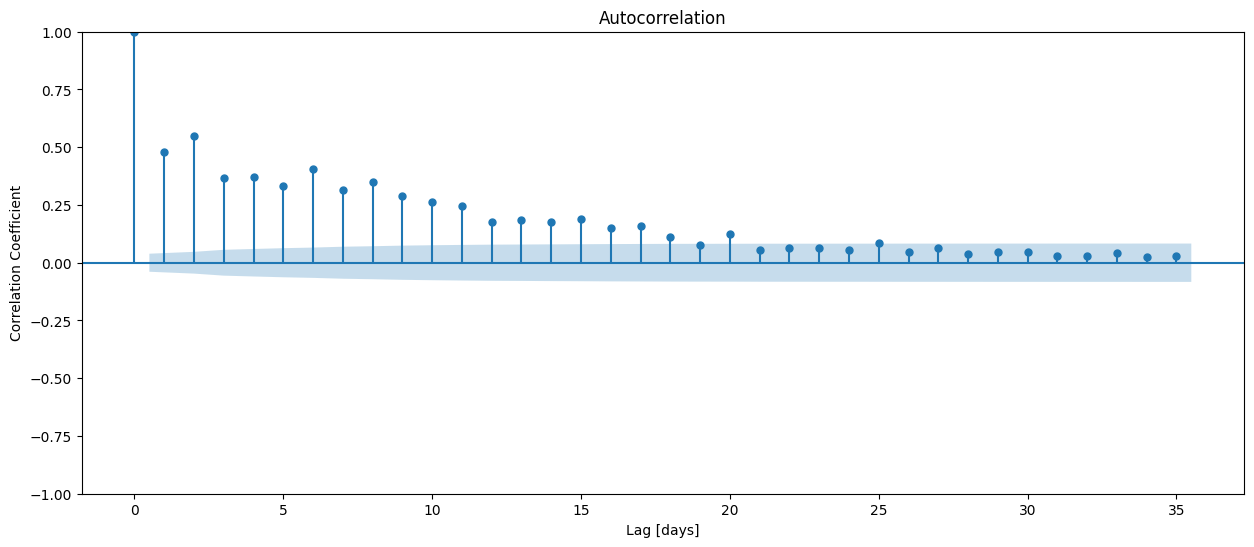

In [8]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared returns
plot_acf(y**2, ax=ax)

# Add axis labels
plt.xlabel('Lag [days]')
plt.ylabel('Correlation Coefficient');

c:\Users\Vignesh\.virtualenvs\Volatility-8aJlLOof\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


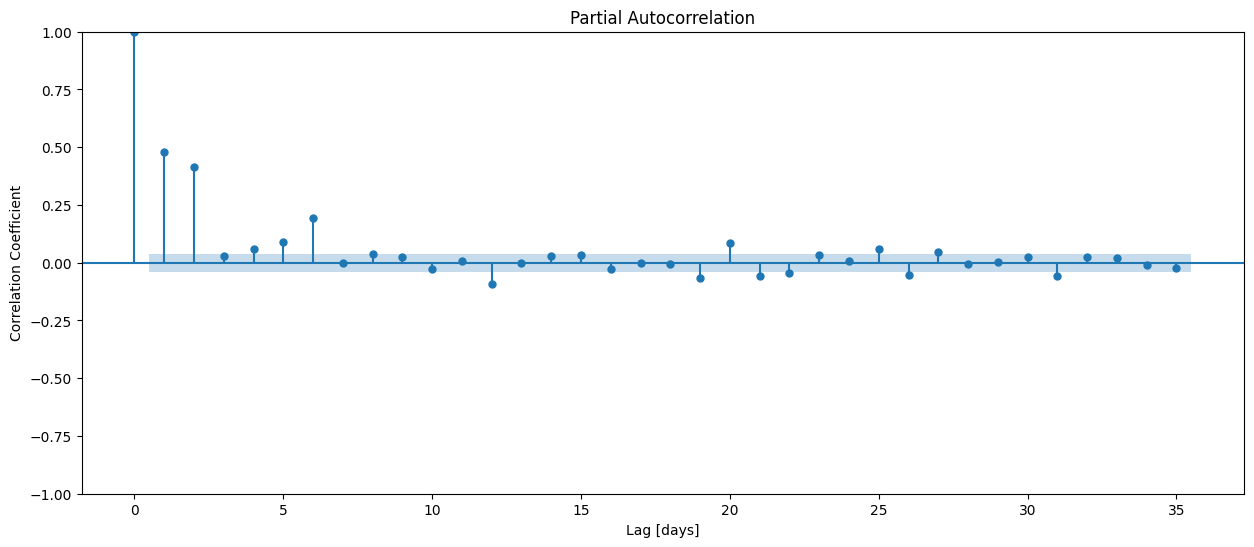

In [48]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create PACF of squared returns
plot_pacf(y**2, ax=ax)

# Add axis labels
plt.xlabel('Lag [days]')
plt.ylabel('Correlation Coefficient');

#### Initial selection (p,q) values GARCH model:
> Based on the PACF we can see that 2 lags would be a good starting point. So we begin with a (2,2) GARCH model.

## Model

### Split Train/Test data

In [6]:
cutoff_test = int(0.8*len(y))
y_train = y.iloc[:cutoff_test]


### Model Defination and Train

In [7]:
model_test = arch_model(
    y_train,
    p=2,
    q=2,
    rescale=False
).fit(disp=0)
print("model type:", type(model_test))

# Show model summary
model_test.summary()

model type: <class 'arch.univariate.base.ARCHModelResult'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2382.97
Distribution:                  Normal   AIC:                           4777.93
Method:            Maximum Likelihood   BIC:                           4811.58
                                        No. Observations:                 2014
Date:                Mon, May 01 2023   Df Residuals:                     2013
Time:                        00:14:38   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0863  1.485e-02      5.813  6.149e-09 [5.722e-02,  0.115]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.0755  1.831e-02      4.127  3.682e-05 [3.966e-02,  0.111]
alpha[1]       0.2017  4.295e-02      4.697  2.645e-06   [  0.118,  0.286]
alpha[2]       0.1932  4.061e-02      4.759  1.946e-06   [  0.114,  0.273]
beta[1]    4.0365e-03  8.513e-02  4.742e-02      0.962   [ -0.163,  0.171]
beta[2]        0.5331  6.196e-02      8.603  7.748e-18   [  0.412,  0.655]
==========================================================================

Covariance estimator: robust
"""

In [9]:
model = arch_model(
    y_train,
    p=1,
    q=1,
    rescale=False
).fit(disp=0)
#print("model type:", type(model))

# Show model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2383.86
Distribution:                  Normal   AIC:                           4775.73
Method:            Maximum Likelihood   BIC:                           4798.16
                                        No. Observations:                 2014
Date:                Mon, May 01 2023   Df Residuals:                     2013
Time:                        00:14:59   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0874  1.480e-02      5.906  3.511e-09 [5.839e-02,  0.116]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0422  1.015e-02      4.159  3.196e-05 [2.232e-02,6.211e-02]
alpha[1]       0.2228  3.355e-02      6.639  3.159e-11     [  0.157,  0.289]
beta[1]        0.7396  2.972e-02     24.881 1.195e-136     [  0.681,  0.798]
============================================================================

Covariance estimator: robust
"""

<b>Selection best GARCH model:</b>
> Based on the summary of bot models we can see that there is not much change in AIC, BIC scores, but the (1,1) model has more significant values of the hyperparameters than (2, 2). So we move forward with (1,1) model.

## Model Performance Metrics(trained data)

### Graph of daily return vs predicted range

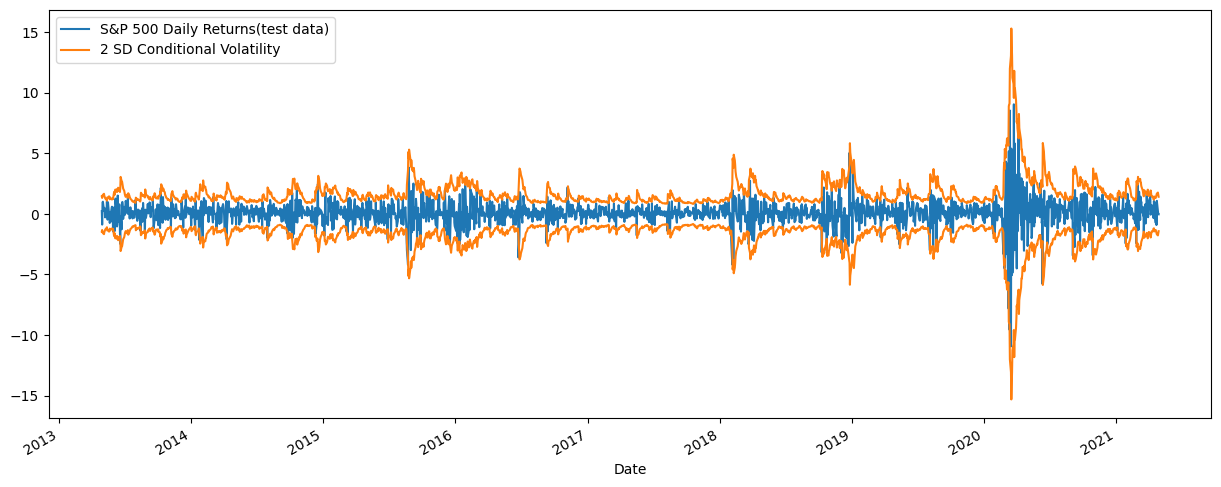

In [10]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_ambuja_train`
y_train.plot(ax=ax, label="S&P 500 Daily Returns(test data)")


# Plot conditional volatility * 2
(2*model.conditional_volatility).plot(ax=ax, color="C1", label="2 SD Conditional Volatility")

# Plot conditional volatility * -2
(-2*model.conditional_volatility.rename()).plot(ax=ax, color="C1")



# Add axis labels

plt.xlabel("Date")

# Add legend
plt.legend()

### Residuals

#### Histogram for Standard Residuals of the Model

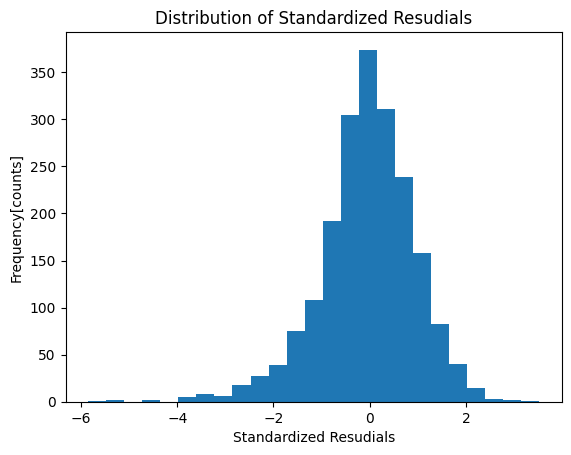

In [11]:
plt.hist(model.std_resid,bins=25)

# Add axis labels
plt.ylabel('Frequency[counts]')

plt.xlabel('Standardized Resudials')
# Add title
plt.title('Distribution of Standardized Resudials');

#### ACF Plot for Standard Residuals of the Model

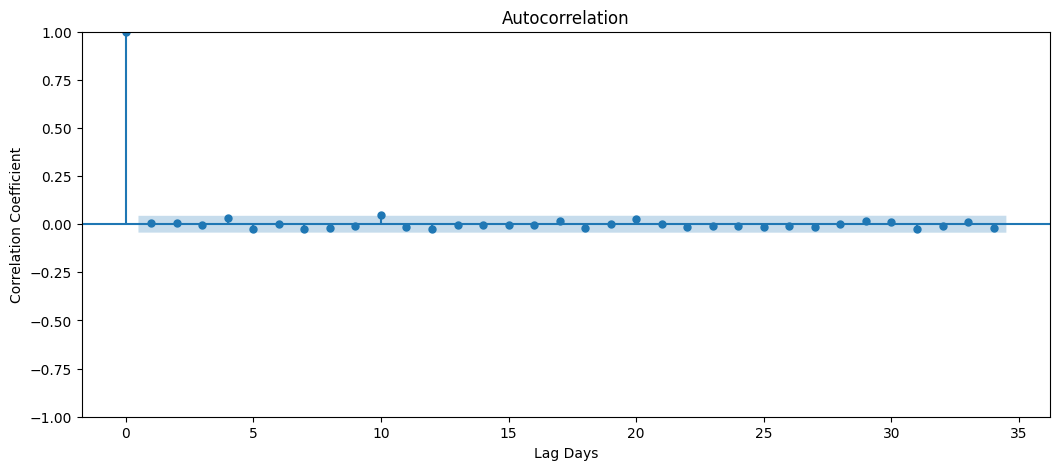

In [12]:
fig, ax = plt.subplots(figsize=(12.5, 5))

# Create ACF of squared, standardized residuals
plot_acf(model.std_resid**2, ax=ax)

# Add axis labels
plt.xlabel("Lag Days")
plt.ylabel("Correlation Coefficient");

<b>Summary of Residuals</b>
1. The Distribution of Standardized Resudials shows that residuals roughly follow normal distribuation, which is good.
2. The ACF plot shows that there is no correlation between residuals in terms of lag days.

## Model Evaluation

### Walk Forward Evaluation Results

In [13]:
# Create empty list to hold predictions
predictions = []

# Calculate size of test data (20%)
test_size = int(len(y) * 0.2)

# Walk forward
for i in range(test_size):
    # Create test data
    y_train = y.iloc[: -(test_size - i)]

    # Train model
    model = arch_model(
    y_train,
    p=1,
    q=1,
    rescale=False
).fit(disp=0)

    # Generate next prediction (volatility, not variance)
    next_pred = model.forecast(horizon=1, reindex=False).variance.iloc[0,0] ** 0.5

    # Append prediction to list
    predictions.append(next_pred)

# Create Series from predictions list
y_test_wfv = pd.Series(predictions, index=y.tail(test_size).index)

print("y_test_wfv type:", type(y_test_wfv))
print("y_test_wfv shape:", y_test_wfv.shape)
y_test_wfv.head()

y_test_wfv type: <class 'pandas.core.series.Series'>
y_test_wfv shape: (503,)


Date
2021-04-30    0.648024
2021-05-03    0.690193
2021-05-04    0.630882
2021-05-05    0.668503
2021-05-06    0.610931
dtype: float64

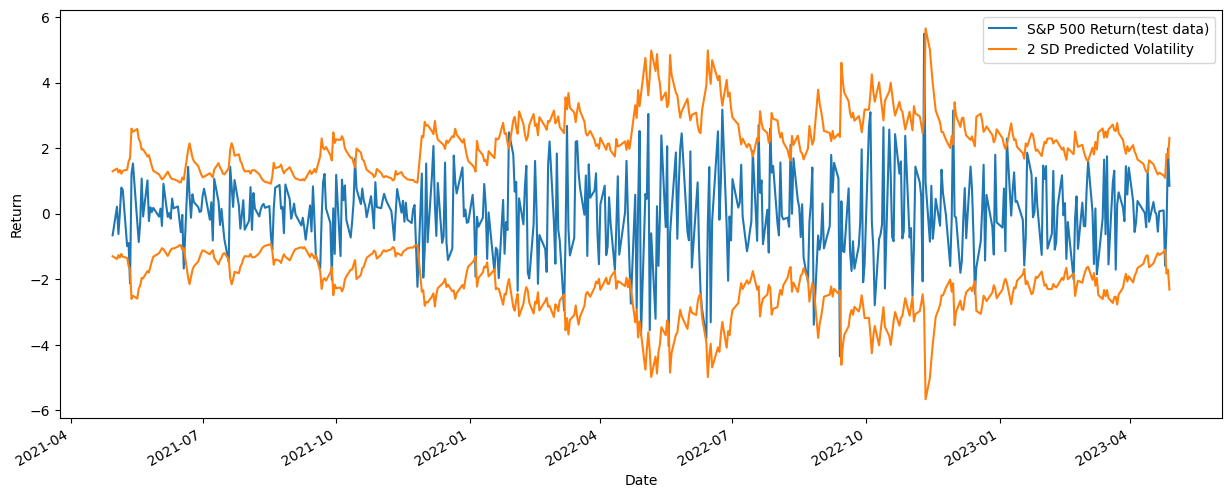

In [37]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for test data
y.tail(test_size).plot(ax=ax, label="S&P 500 Return(test data)")

# Plot volatility predictions * 2
(2 * y_test_wfv).plot(ax=ax, c="C1", label="2 SD Predicted Volatility")

# Plot volatility predictions * -2
(-2 * y_test_wfv).plot(ax=ax, c="C1")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
plt.legend();

In [32]:
import os
import joblib
import pandas as pd
timestamp=pd.Timestamp.now().isoformat()
# Create filepath, including `self.model_directory`
filepath = os.path.join('VolatilityPrediction\prediction\models', f"{timestamp}_{'SPY'}.pkl")
#filepath='model/'+timestamp+'_SPY.pkl'
filepath=filepath.replace(':','-')
print(filepath)
# Save `self.model`
joblib.dump(model, filepath)


VolatilityPrediction\prediction\models\2023-05-01T01-44-33.051237_SPY.pkl


['VolatilityPrediction\\prediction\\models\\2023-05-01T01-44-33.051237_SPY.pkl']